### TO DO
1. data preprocessing
- notes we got: For example, the vote count and popularity score variables may not be good features to use as they are more likely to be response variables. A good rule of thumb is: if there is a new movie that has not been released yet, what features will we have and which will be not have?
2. train linear regression
- use budget & time of year to keep it simple
- flag 
3. train polynomial
- same deal as above
4. train RF
- add categorical vars
5. train adaboost
- same deal

### Data Cleaning
1. do we keep 2020 in there since that year is messed up
2. how do we standardize/ can we keep reviews in there??
3. are we doing profit?

In [1]:
SARA_FILEPATH = '/Users/sarakent/Desktop/ML 1/TMDB_movie_dataset_v11.csv'   #too large to add to git, adding file path here
BECK_FILEPATH = 'C:/Users/becke/OneDrive/Documents/Northeastern Schoolwork/Spring 2024/DS 4400/TMDB_movie_dataset/TMDB_movie_dataset_v11.csv'

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import numpy as np
import math
from scipy.sparse import csr_matrix
import datetime as datetime

In [3]:
df = pd.read_csv(BECK_FILEPATH)
df.head(2)

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,...,Interstellar,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."


In [4]:
df.columns

Index(['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date',
       'revenue', 'runtime', 'adult', 'backdrop_path', 'budget', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'tagline', 'genres',
       'production_companies', 'production_countries', 'spoken_languages',
       'keywords'],
      dtype='object')

In [5]:
# keeping columns we are interested in
# col_lst = ['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date', 'revenue',
#           'runtime', 'adult', 'budget', 'popularity', 'genres', 'production_companies',
#           'spoken_languages']
# df = df[col_lst]
df['release_date'] = pd.to_datetime(df.release_date)
df = df[(df['status'] == 'Released') & 
        (df['budget'] > 10000) & 
        (df['release_date'].notna()) & 
        (df['genres'].notna()) &
        (df['runtime'] != 0) & 
        (df['release_date'] > '1950-01-01') &
        (df['tagline'].notna()) &
        (df['overview'].notna())]

In [6]:
df

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,...,Interstellar,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,...,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f..."
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,False,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,...,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ..."
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,False,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,...,The Avengers,When an unexpected enemy emerges and threatens...,98.082,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018566,676483,Thong Girl Vs Xolta from Outer Space,0.000,0,Released,2014-08-26,0,45,False,/8GeKaukS0TxDe1j32BgrV8gQjpi.jpg,...,Thong Girl Vs Xolta from Outer Space,Thong Girl reluctantly teams up with alien fem...,1.400,/k2KQRsF1g7qLS6yAJOLRWFNDqPC.jpg,"If You Do Wrong, You’ll Answer To The Thong","Fantasy, Science Fiction, Comedy",Lucky Louie Productions,United States of America,English,"superhero, alien, space, sex spoof, thongs, th..."
1018761,676716,Four Bottles,0.000,0,Released,2017-06-10,0,82,False,/1UUZ8M2iJnh1vw3TmWtf0pAUIhH.jpg,...,Four Bottles,After finding out she didn't get her dream job...,0.600,/Aws9rkX4gdDENgTxTVtKfAVdvdg.jpg,After finding out she didn't get her dream job...,"Comedy, Drama",Words From Here Productions,United States of America,English,NaN
1018829,673274,Chicheka Lullaby,0.000,0,Released,2018-11-07,0,97,False,/1TDiBzq1eFPxT0RXMG61V1PiX.jpg,...,چی‌چکا قصه‌ی شب,Sound and scenes from south of Iran. The story...,0.600,/mvGwYHOJYeiPxbdFjEzhAVgeApo.jpg,The sound of pain and freedom,"Documentary, Music",NaN,Iran,Persian,"folk music, chicheka lullaby, چی‌چکا قصه‌ی شب,..."
1019657,674780,Young Love,0.000,0,Released,2019-11-07,300000,112,False,NaN,...,ស្នេហាក្មេងៗ,Kali a 16 year old girl in Phnom Penh Cambodia...,0.602,/tt68RQ7qaGSkwYvdPWn2ZrOYHgv.jpg,NOTHING IS LIKE YOUNG LOVE.,Romance,"Kongchak Pictures, Westec Media Limited",Cambodia,Khmer,NaN


In [7]:
df['profit'] = df.revenue - df.budget

In [8]:
df.profit.mean(), df.profit.max(), df.profit.min()

(28317818.223541334, 2686706026, -185600000)

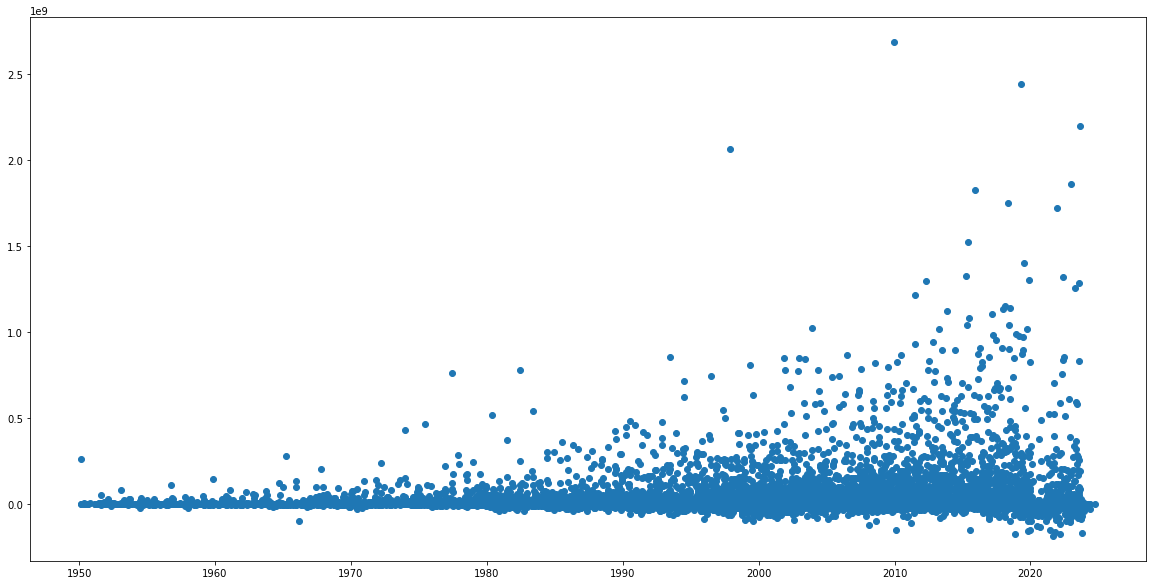

In [9]:
plt.figure(figsize=(20, 10))
plt.scatter(df.release_date, df.profit)
plt.show()

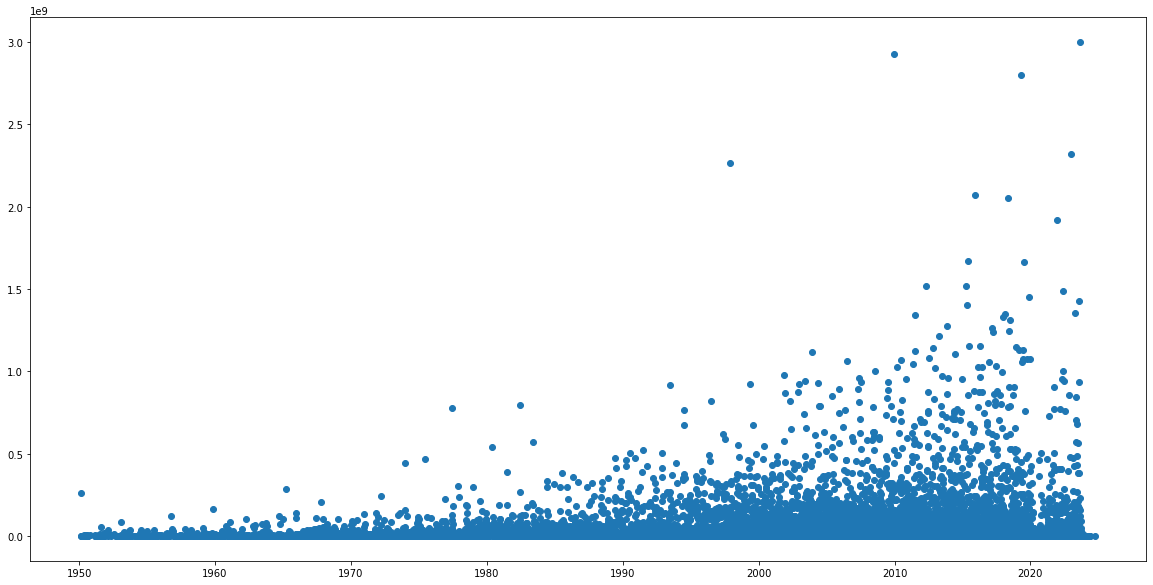

In [10]:
plt.figure(figsize=(20, 10))
plt.scatter(df.release_date, df.revenue)
plt.show()

In [11]:
df=df[df.tagline.notna() & df.overview.notna()]

In [12]:
# Download NLTK stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Get the English stopwords list
stop_words = set(stopwords.words('english'))


# Function to remove stopwords and numbers from text
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    # Tokenize text
    words = text.split()
    
    # Remove stopwords and numbers
    filtered_words = filtered_words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words and not word.isdigit()]
    
    # Join the filtered words back into a single string
    processed_text = ' '.join(filtered_words)
    
    return processed_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\becke\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\becke\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\becke\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [13]:
df.reset_index(inplace=True)

In [14]:
# Combine text fields into one
df['text'] = df['original_title'] + ' ' + df['overview'] + ' ' + df['tagline']
ids = df['id']

# Initialize CountVectorizer to convert text into word frequency vectors
df['text'] = df['text'].apply(preprocess_text)
vectorizer = CountVectorizer()

# Fit and transform the combined text to get the word frequency vectors
word_freq_matrix = vectorizer.fit_transform(df['text'])

# Convert the word frequency matrix to a DataFrame
word_freq_df = pd.DataFrame(word_freq_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Calculate the sum of occurrences of each word across rows
word_freq_sum = word_freq_df.sum()
# Calculate the percentile threshold (e.g., top 25th percentile)
percentile_threshold = np.percentile(word_freq_sum, 99.8)  # Keep words within the top 25th percentile

# Filter to include only columns where the frequency is within the percentile threshold
significant_word_freq = word_freq_df.loc[:, word_freq_sum >= percentile_threshold]
word_freqs = pd.concat([ids, significant_word_freq], axis=1)

In [15]:
""" Had a memory error once with the above kernel so this is a workaround if it doesn't work for some reason """

# # Combine text fields into one
# df['text'] = df['original_title'] + ' ' + df['overview'] + ' ' + df['tagline']
# ids = df['id']

# # Initialize CountVectorizer to convert text into word frequency vectors
# df['text'] = df['text'].apply(preprocess_text)
# vectorizer = CountVectorizer()

# # Fit and transform the combined text to get the word frequency vectors
# word_freq_matrix = vectorizer.fit_transform(df['text'])

# # Calculate the sum of occurrences of each word across rows directly on the sparse matrix
# word_freq_sum = np.array(word_freq_matrix.sum(axis=0)).ravel()

# # Calculate the percentile threshold (e.g., top 0.2 percentile for high frequency words)
# percentile_threshold = np.percentile(word_freq_sum, 99.8)

# # Identify columns (words) that exceed the threshold
# important_columns = word_freq_sum > percentile_threshold

# # Filter the matrix to keep only these important columns
# filtered_matrix = word_freq_matrix[:, important_columns]

# # If you need the names of these words, you can filter the feature names as well
# feature_names = vectorizer.get_feature_names_out()
# important_features = feature_names[important_columns]

# # convert the filtered sparse matrix to a DataFrame for further analysis
# word_freqs = pd.DataFrame(filtered_matrix.toarray(), columns=important_features)

# # Add the 'id' column from the original DataFrame
# word_freqs['id'] = ids.values

# # Optionally, you might want to rearrange columns to put 'id' at the front
# cols = ['id'] + [col for col in word_freqs.columns if col != 'id']
# word_freqs = word_freqs[cols]

" Had a memory error once with the above kernel so this is a workaround if it doesn't work for some reason "

In [16]:
word_freqs

,id,american,back,become,becomes,begin,best,boy,brother,city,...,try,turn,two,war,way,wife,woman,world,year,young
0,27205,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,157336,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,155,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,19995,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,24428,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13809,676483,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13810,676716,0,2,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
13811,673274,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13812,674780,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,2


In [17]:
features = df[['id', 'genres', 'title', 'budget', 'release_date', 'production_companies']]

In [18]:
features

,id,genres,title,budget,release_date,production_companies
0,27205,"Action, Science Fiction, Adventure",Inception,160000000,2010-07-15,"Legendary Pictures, Syncopy, Warner Bros. Pict..."
1,157336,"Adventure, Drama, Science Fiction",Interstellar,165000000,2014-11-05,"Legendary Pictures, Syncopy, Lynda Obst Produc..."
2,155,"Drama, Action, Crime, Thriller",The Dark Knight,185000000,2008-07-16,"DC Comics, Legendary Pictures, Syncopy, Isobel..."
3,19995,"Action, Adventure, Fantasy, Science Fiction",Avatar,237000000,2009-12-15,"Dune Entertainment, Lightstorm Entertainment, ..."
4,24428,"Science Fiction, Action, Adventure",The Avengers,220000000,2012-04-25,Marvel Studios
...,...,...,...,...,...,...
13809,676483,"Fantasy, Science Fiction, Comedy",Thong Girl Vs Xolta from Outer Space,30000,2014-08-26,Lucky Louie Productions
13810,676716,"Comedy, Drama",Four Bottles,38000,2017-06-10,Words From Here Productions
13811,673274,"Documentary, Music",Chicheka Lullaby,17792,2018-11-07,NaN
13812,674780,Romance,Young Love,100000,2019-11-07,"Kongchak Pictures, Westec Media Limited"


In [19]:
final_df = word_freqs.join(features.set_index('id'), on='id', lsuffix='_word_freqs', rsuffix='_df')

In [20]:
final_df['genres'] = final_df['genres'].apply(lambda x: x.split(',')[0])
final_df['production_companies'] = final_df['production_companies'].apply(
    lambda x: x.split(',')[0] if isinstance(x,str) else x)

In [21]:
final_df['release_date'] = final_df['release_date'].apply(lambda x: x.month)

In [22]:
final_df

,id,american,back,become,becomes,begin,best,boy,brother,city,...,wife,woman,world,year,young,genres,title,budget,release_date,production_companies
0,27205,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Action,Inception,160000000,7,Legendary Pictures
1,157336,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Adventure,Interstellar,165000000,11,Legendary Pictures
2,155,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,Drama,The Dark Knight,185000000,7,DC Comics
3,19995,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,Action,Avatar,237000000,12,Dune Entertainment
4,24428,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,Science Fiction,The Avengers,220000000,4,Marvel Studios
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13809,676483,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Fantasy,Thong Girl Vs Xolta from Outer Space,30000,8,Lucky Louie Productions
13810,676716,0,2,0,0,0,0,0,0,2,...,0,0,0,0,0,Comedy,Four Bottles,38000,6,Words From Here Productions
13811,673274,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Documentary,Chicheka Lullaby,17792,11,NaN
13812,674780,0,0,0,0,1,0,0,0,0,...,0,0,0,1,2,Romance,Young Love,100000,11,Kongchak Pictures


## Genre Specific Data Exploration

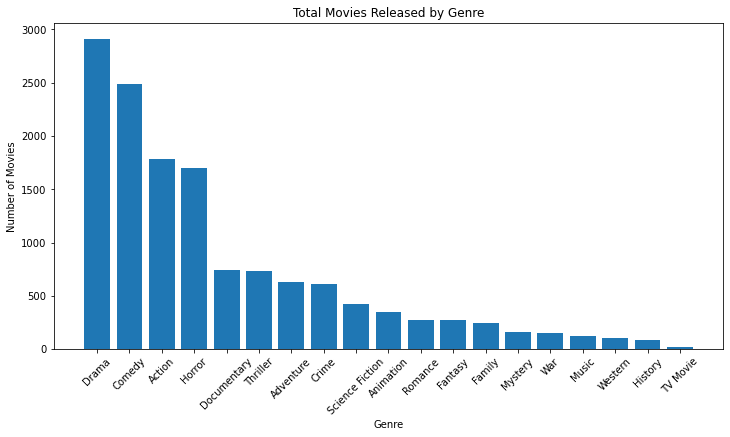

In [23]:
genre_counts = final_df.genres.value_counts()

# Creating the bar chart
plt.figure(figsize=(12, 6))
plt.bar(genre_counts.index, genre_counts.values)
plt.title('Total Movies Released by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

## Production Company Data Exploration

In [24]:
production_df = final_df.dropna(subset=['production_companies'])

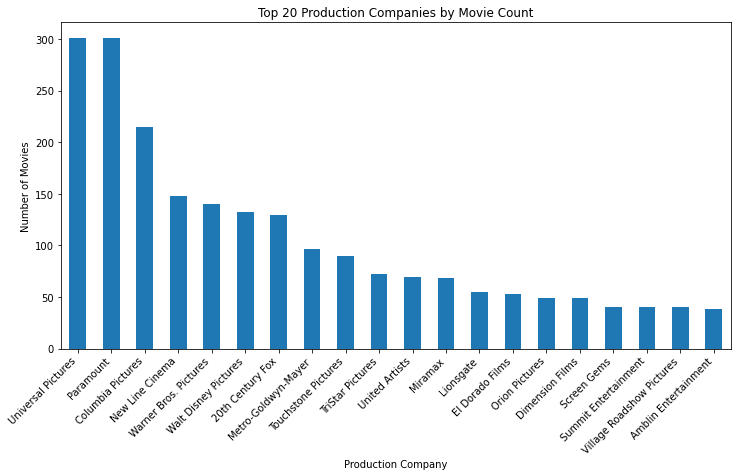

In [28]:
production_counts = production_df['production_companies'].value_counts().head(20)

# Plotting the data
plt.figure(figsize=(12, 6))
production_counts.plot(kind='bar')
plt.title('Top 20 Production Companies by Movie Count')
plt.xlabel('Production Company')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.show()

In [29]:
# Count movies per production company and genre
genre_counts = production_df.groupby(['production_companies', 'genres']).size().unstack(fill_value=0)

# Sum the counts to find the top 20 production companies
top_companies = genre_counts.sum(axis=1).nlargest(20).index

# Filter the data to only include these top companies
top_genre_counts = genre_counts.loc[top_companies]

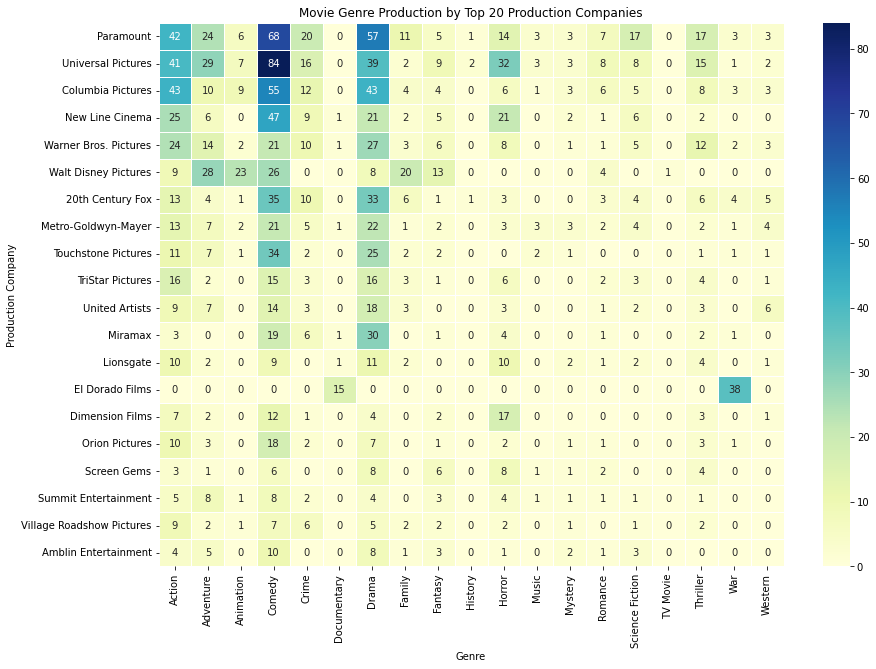

In [31]:
plt.figure(figsize=(14, 10))  # Adjust size as necessary
sns.heatmap(top_genre_counts, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5)
plt.title('Movie Genre Production by Top 20 Production Companies')
plt.xlabel('Genre')
plt.ylabel('Production Company')
plt.show()

In [32]:
# Calculate the total movies produced by each company
company_totals = top_genre_counts.sum(axis=1)

# Calculate the percentage of each genre for each production company
genre_percentages = top_genre_counts.div(company_totals, axis=0) * 100

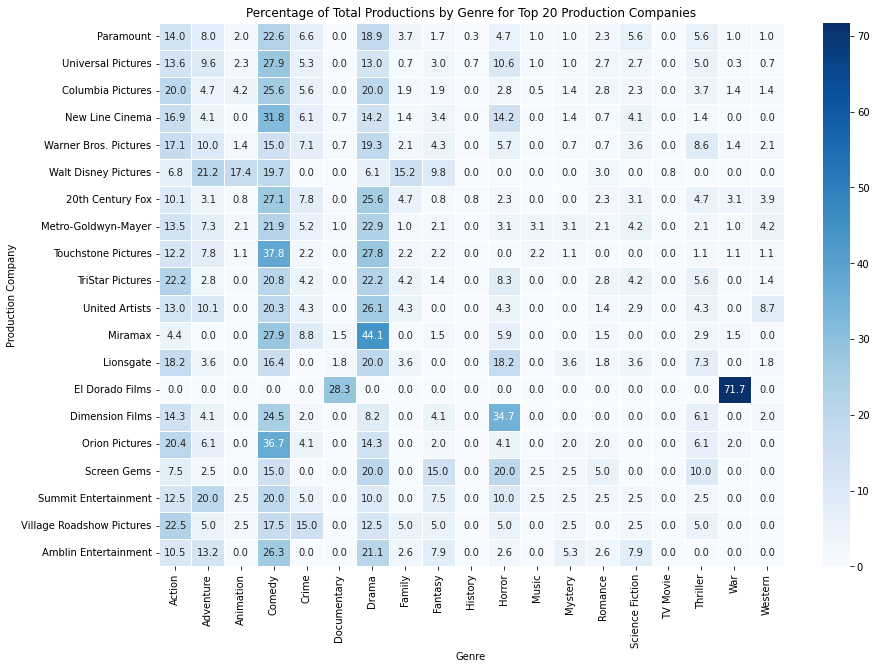

In [33]:
plt.figure(figsize=(14, 10))  # Adjust size as necessary
sns.heatmap(genre_percentages, annot=True, fmt=".1f", cmap="Blues", linewidths=.5)
plt.title('Percentage of Total Productions by Genre for Top 20 Production Companies')
plt.xlabel('Genre')
plt.ylabel('Production Company')
plt.show()

In [34]:
# Calculate the total movies for each genre across all companies
genre_totals = top_genre_counts.sum(axis=0)

# Calculate the percentage of each company's contribution to each genre
company_genre_percentages = (top_genre_counts.div(genre_totals, axis=1) * 100).fillna(0)

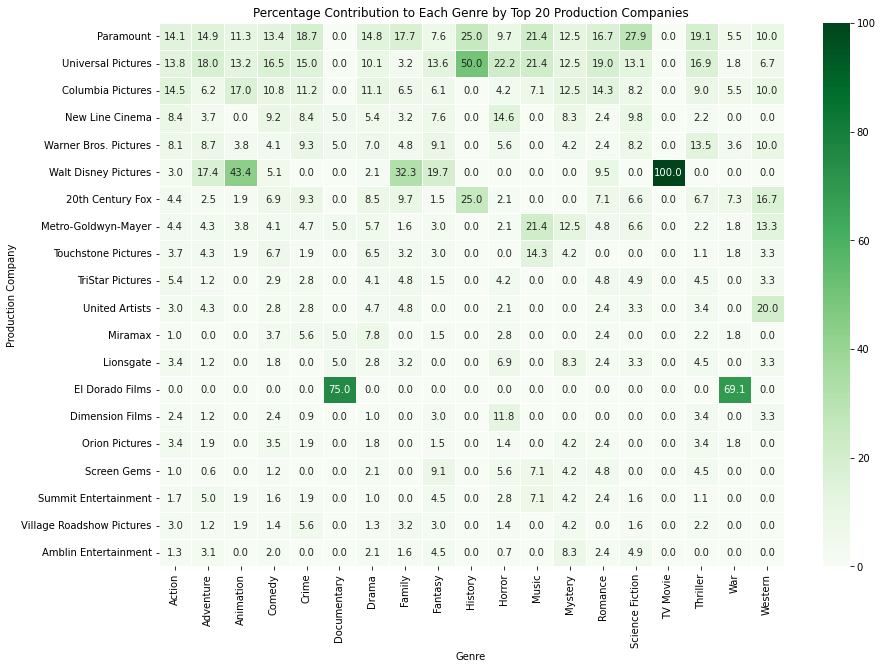

In [35]:
plt.figure(figsize=(14, 10))  # Adjust size as necessary
sns.heatmap(company_genre_percentages, annot=True, fmt=".1f", cmap="Greens", linewidths=.5)
plt.title('Percentage Contribution to Each Genre by Top 20 Production Companies')
plt.xlabel('Genre')
plt.ylabel('Production Company')
plt.show()

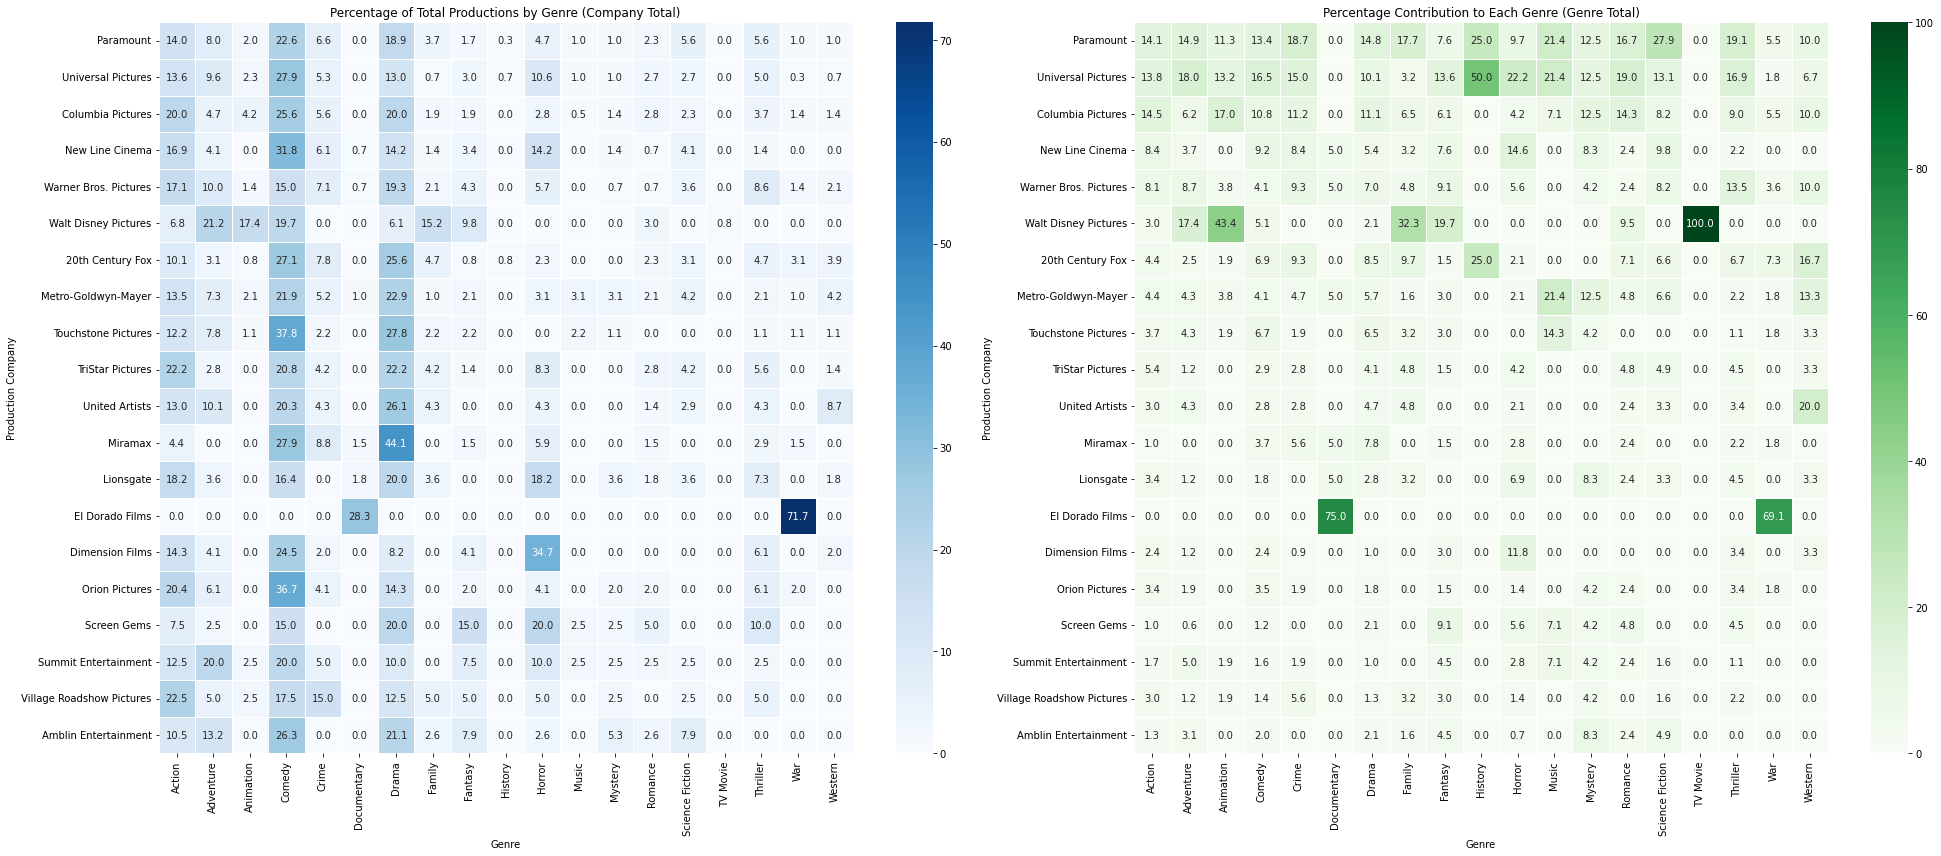

In [36]:
fig, ax = plt.subplots(ncols=2, figsize=(28, 12))

# Heatmap for percentage of total productions by genre for each company
sns.heatmap(genre_percentages, annot=True, fmt=".1f", cmap="Blues", linewidths=.5, ax=ax[0])
ax[0].set_title('Percentage of Total Productions by Genre (Company Total)')
ax[0].set_xlabel('Genre')
ax[0].set_ylabel('Production Company')

# Heatmap for percentage contribution to each genre by company
sns.heatmap(company_genre_percentages, annot=True, fmt=".1f", cmap="Greens", linewidths=.5, ax=ax[1])
ax[1].set_title('Percentage Contribution to Each Genre (Genre Total)')
ax[1].set_xlabel('Genre')
ax[1].set_ylabel('Production Company')

plt.tight_layout()  # Adjust layout to fit everything neatly
plt.show()

## Release Date and Genre Data Exploration

In [37]:
month_map = {
    1: "January", 2: "February", 3: "March", 4: "April",
    5: "May", 6: "June", 7: "July", 8: "August",
    9: "September", 10: "October", 11: "November", 12: "December"
}

date_df = final_df.dropna(subset=['release_date'])
date_df['release_date'] = date_df['release_date'].map(month_map)

monthly_counts = date_df['release_date'].value_counts().reindex([
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
])
monthly_counts

January      1100
February      920
March        1163
April        1039
May          1076
June         1139
July          995
August       1149
September    1413
October      1494
November     1096
December     1234
Name: release_date, dtype: int64

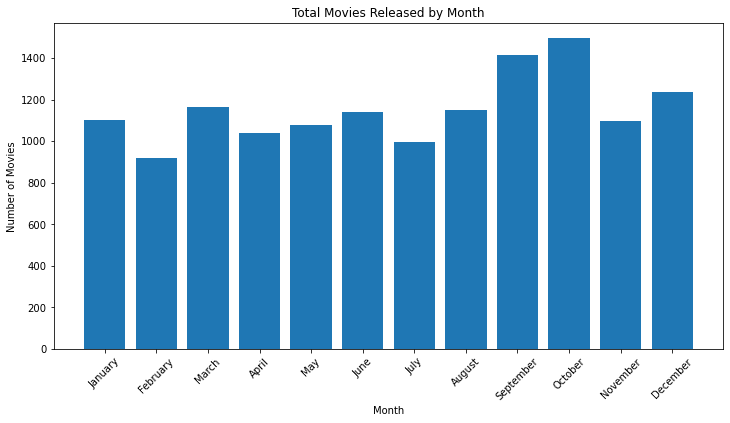

In [38]:
# Creating the bar chart
plt.figure(figsize=(12, 6))
plt.bar(monthly_counts.index, monthly_counts.values)
plt.title('Total Movies Released by Month')
plt.xlabel('Month')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

In [39]:
# Aggregate data: count movies by month and genre
month_genre_counts = date_df.groupby(['release_date', 'genres']).size().unstack(fill_value=0)

# Reindex to ensure all months are in proper order
month_genre_counts = month_genre_counts.reindex([
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
])

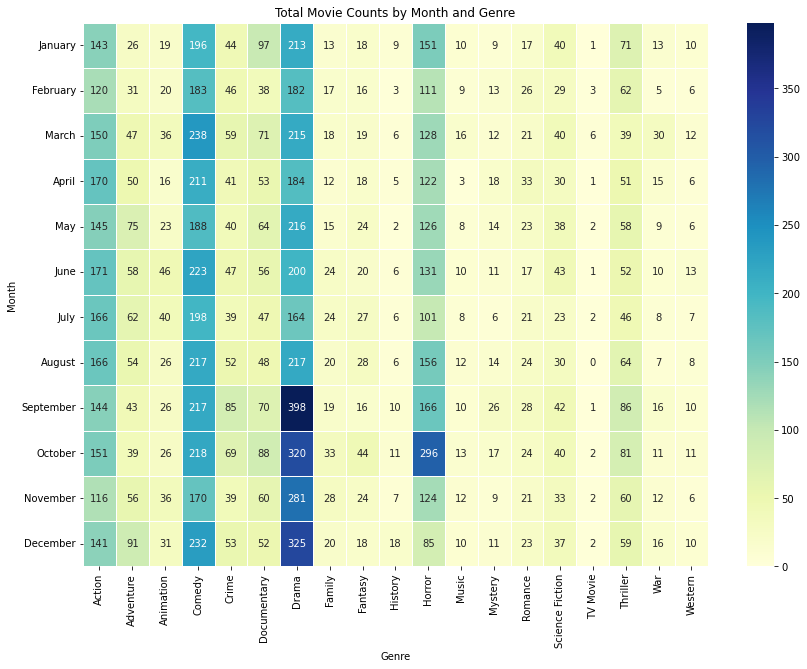

In [40]:
plt.figure(figsize=(14, 10))
sns.heatmap(month_genre_counts, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5)
plt.title('Total Movie Counts by Month and Genre')
plt.xlabel('Genre')
plt.ylabel('Month')
plt.show()

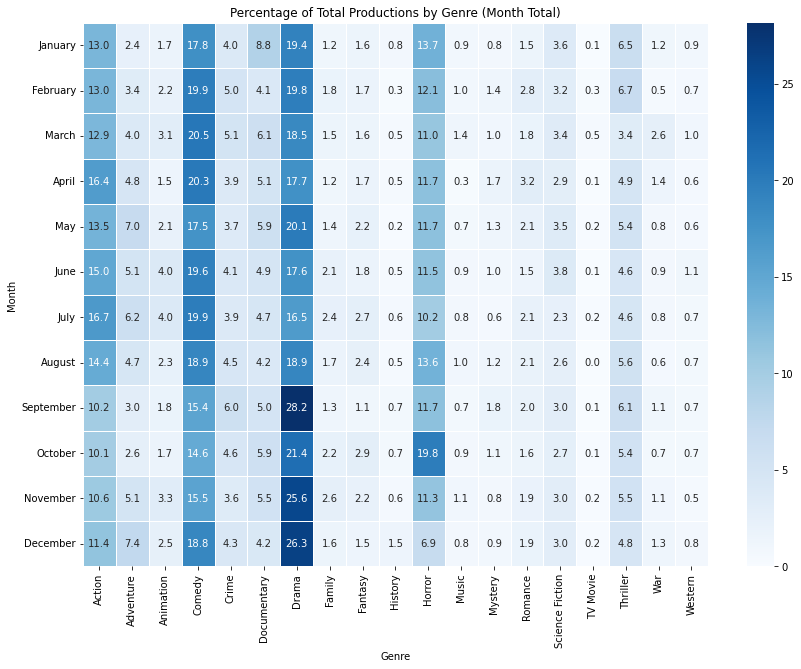

In [41]:
# Calculate the total movies produced each month
month_totals = month_genre_counts.sum(axis=1)

# Calculate the percentage of each genre for each month
genre_percentages_by_month = month_genre_counts.div(month_totals, axis=0) * 100

plt.figure(figsize=(14, 10))
sns.heatmap(genre_percentages_by_month, annot=True, fmt=".1f", cmap="Blues", linewidths=.5)
plt.title('Percentage of Total Productions by Genre (Month Total)')
plt.xlabel('Genre')
plt.ylabel('Month')
plt.show()

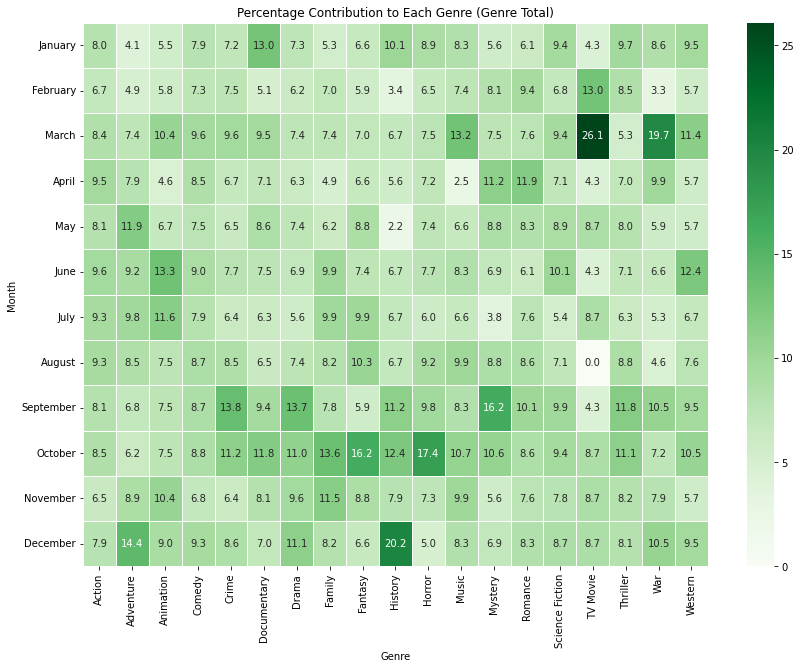

In [42]:
# Calculate the total movies for each genre across all months
genre_totals = month_genre_counts.sum(axis=0)

# Calculate the percentage contribution of each month to each genre
month_genre_percentages = month_genre_counts.div(genre_totals, axis=1) * 100

plt.figure(figsize=(14, 10))
sns.heatmap(month_genre_percentages, annot=True, fmt=".1f", cmap="Greens", linewidths=.5)
plt.title('Percentage Contribution to Each Genre (Genre Total)')
plt.xlabel('Genre')
plt.ylabel('Month')
plt.show()

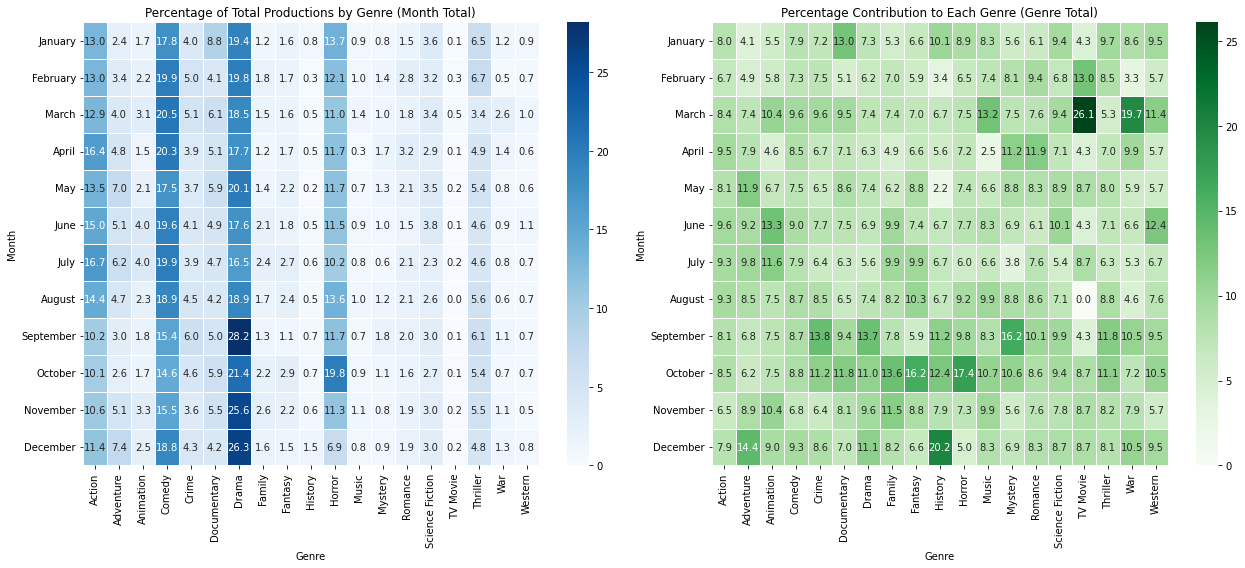

In [43]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Heatmap 1: Percentage of Total Productions by Genre (Month Total)
sns.heatmap(genre_percentages_by_month, annot=True, fmt=".1f", cmap="Blues", linewidths=.5, ax=axes[0])
axes[0].set_title('Percentage of Total Productions by Genre (Month Total)')
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Month')

# Heatmap 2: Percentage Contribution to Each Genre (Genre Total)
sns.heatmap(month_genre_percentages, annot=True, fmt=".1f", cmap="Greens", linewidths=.5, ax=axes[1])
axes[1].set_title('Percentage Contribution to Each Genre (Genre Total)')
axes[1].set_xlabel('Genre')
axes[1].set_ylabel('Month')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [44]:
#final_df.to_csv('movie.csv')